# Install Prequisites

In [1]:
!pip install pandas
!pip install numpy
!pip install scapy
!pip install scikit-learn
!pip install matplotlib

# Import prerequisite libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from lib import utilities as utils

# Settings Definition

In [3]:
COVERT_FILES = [
    "data/covert/l3_covert.pcap",
    "data/covert/l4_covert.pcap",
    "data/covert/covert_tcp.pcap",
    "data/covert/covert_frag.pcap",
    "data/covert/covert_icmp.pcap",
]
NON_COVERT_FILES = [
    "data/non-covert/icmp_echo_1k.pcap",
    "data/non-covert/non_covert_250k.pcap",
]
COVERT_FILE_READ_LIMIT=2000
COVERT_MAX_LIMIT=-1
NON_COVERT_FILE_READ_LIMIT=-1
NON_COVERT_MAX_LIMIT=10000
TEST_SIZE=0.2

# Read-in Covert Files

In [4]:
covert_train, covert_test = utils.read_data(
    COVERT_FILES,
    maximum_count=COVERT_MAX_LIMIT,
    file_count=COVERT_FILE_READ_LIMIT,
    covert=1,
    test_size=TEST_SIZE
)

# Read-in Non-Covert Files

In [5]:
non_covert_train, non_covert_test = utils.read_data(
    NON_COVERT_FILES,
    maximum_count=NON_COVERT_MAX_LIMIT,
    file_count=NON_COVERT_FILE_READ_LIMIT,
    covert=0,
    test_size=TEST_SIZE
)

# Prepare Training Data

In [6]:
all_train = utils.randomize_dataframe([covert_train, non_covert_train])
all_train.reset_index()
all_train_labels = all_train["is_covert"].copy()
all_train.drop(labels=["is_covert"], axis=1, inplace=True)

# Prepare Testing Data

In [7]:
all_test = utils.randomize_dataframe([covert_test, non_covert_test])
all_test.reset_index()
all_test_labels = all_test["is_covert"].copy()
all_test.drop(labels=["is_covert"], axis=1, inplace=True)

# Scale All Data

In [8]:
scaler = StandardScaler()
all_train = scaler.fit_transform(all_train)
all_test = scaler.transform(all_test)

# Using KNN Algorithm
## Optimize Hyperparameters

In [9]:
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1, 41))
grid_params = {
    'n_neighbors': k_range,
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
d:\projects\cber710\final\env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.99949999        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(


## Display Optimization Graph

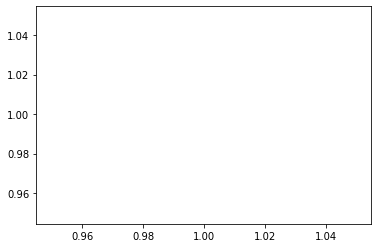

In [10]:
scores = gs_results.cv_results_['mean_test_score']
plt.plot(k_range, scores)
plt.show()

## Show Optimized Hyperparameters

In [11]:
gs_results.best_params_

{'n_neighbors': 1}

## Train Using Optimized Hyperparameters

In [12]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(all_train, all_train_labels)

KNeighborsClassifier(n_neighbors=2)

## Predict Using Generated KNN Model and Display Performance Results

In [13]:
knn_predictions = knn.predict(all_test)
knn_cm = confusion_matrix(all_test_labels, knn_predictions)
knn_precision = precision_score(all_test_labels, knn_predictions)
knn_recall = recall_score(all_test_labels, knn_predictions)
knn_f1 = f1_score(all_test_labels, knn_predictions)

knn_cm, knn_precision, knn_recall, knn_f1

(array([[2000,    0],
        [   2, 1998]], dtype=int64),
 1.0,
 0.999,
 0.9994997498749374)

# Naive Bayes
## Optimize Hyperparameters

In [14]:
from sklearn.naive_bayes import GaussianNB

smoothing_range = np.logspace(0, -9, 100)
grid_params = {
    'var_smoothing': smoothing_range,
}

gs = GridSearchCV(
    GaussianNB(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


## Display Optimization Graph

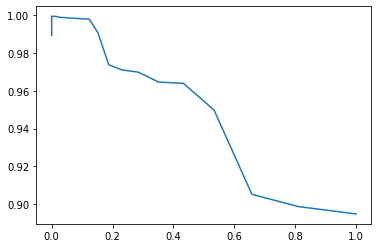

In [15]:
scores = gs_results.cv_results_['mean_test_score']
plt.plot(smoothing_range, scores)
plt.show()

## Show Optimized Hyperparameters

In [16]:
gs_results.best_params_

{'var_smoothing': 0.0012328467394420659}

## Train Using Optimized Hyperparameters

In [17]:
nb = GaussianNB(var_smoothing=0.0012328467394420659)
nb.fit(all_train, all_train_labels)

GaussianNB(var_smoothing=0.0012328467394420659)

## Predict Using Generated Gausian Naive Bayes Model and Display Performance Results

In [18]:
nb_predictions = nb.predict(all_test)
nb_cm = confusion_matrix(all_test_labels, nb_predictions)
nb_precision = precision_score(all_test_labels, nb_predictions)
nb_recall = recall_score(all_test_labels, nb_predictions)
nb_f1 = f1_score(all_test_labels, nb_predictions)

nb_cm, nb_precision, nb_recall, nb_f1

(array([[2000,    0],
        [   2, 1998]], dtype=int64),
 1.0,
 0.999,
 0.9994997498749374)

# Logistic Regression
## Optimize Hyperparameters

In [19]:
from sklearn.linear_model import LogisticRegression

penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [100, 10, 1.0, 0.1, 0.01]

grid_params = {
    'penalty': penalty,
    'solver': solver,
    'C': C,
}

gs = GridSearchCV(
    LogisticRegression(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
d:\projects\cber710\final\env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.99899998        nan 0.99918747 0.99899998
 0.99899998 0.99899998 0.99918747 0.99918747        nan        nan
        nan        nan        nan 0.99925    0.99925           nan
 0.99918747 0.99918747        nan        nan 0.99899998        nan
 0.99918747 0.99912499 0.99912499 0.99912499 0.99918747 0.99918747
        nan        nan        nan        nan        nan 0.99925
 0.99925           nan 0.99918747 0.99918747        nan        nan
 0.99924998        nan 0.99912498 0.99918747 0.99918747 0.99918747
 0.99918747 0.99918747        nan        nan        nan        nan
        nan 0.99925    0.99925           nan 0.99918747 0.99918747
        nan        nan 0.99887498        nan 0.99887498 0.99881247
 0.99881247 0.99881247 0.99881247 0.99881247        nan

## Show Optimized Hyperparameters

In [20]:
gs_results.best_params_

{'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}

## Train Using Optimized Hyperparameters

In [21]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lr.fit(all_train, all_train_labels)

LogisticRegression(penalty='l1', solver='liblinear')

## Predict Using Generated Logistic Regression Model and Display Performance Results

In [22]:
lr_predictions = lr.predict(all_test)
lr_cm = confusion_matrix(all_test_labels, lr_predictions)
lr_precision = precision_score(all_test_labels, lr_predictions)
lr_recall = recall_score(all_test_labels, lr_predictions)
lr_f1 = f1_score(all_test_labels, lr_predictions)

lr_cm, lr_precision, lr_recall, lr_f1

(array([[1999,    1],
        [   2, 1998]], dtype=int64),
 0.9994997498749375,
 0.999,
 0.9992498124531133)

# Decision Trees
## Optimize Hyperparameters

In [23]:
from sklearn.tree import DecisionTreeClassifier

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [1, 2, 3, None]


grid_params = {
    'criterion': criterion,
    'splitter': splitter,
    'max_depth': max_depth,
}

gs = GridSearchCV(
    DecisionTreeClassifier(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


## Show Optimized Hyperparameters

In [24]:
gs_results.best_params_

{'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}

## Train Using Optimized Hyperparameters

In [25]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=None, splitter='best')
dtc.fit(all_train, all_train_labels)

DecisionTreeClassifier()

## Predict Using Generated Decision Tree Model and Display Performance Results

In [26]:
dtc_predictions = dtc.predict(all_test)
dtc_cm = confusion_matrix(all_test_labels, dtc_predictions)
dtc_precision = precision_score(all_test_labels, dtc_predictions)
dtc_recall = recall_score(all_test_labels, dtc_predictions)
dtc_f1 = f1_score(all_test_labels, dtc_predictions)

dtc_cm, dtc_precision, dtc_recall, dtc_f1

(array([[2000,    0],
        [   2, 1998]], dtype=int64),
 1.0,
 0.999,
 0.9994997498749374)

# Support Vector Machine
## Optimize Hyperparameters

In [27]:
from sklearn.svm import LinearSVC

penalty = ['l1', 'l2']
loss = ['hinge', 'squared_hinge']
dual = [True, False]
C = [100.0, 10.0, 1.0, 0.1, 0.01]

grid_params = {
    'penalty': penalty,
    'loss': loss,
    'dual': dual,
    'C': C,
}

gs = GridSearchCV(
    LinearSVC(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
d:\projects\cber710\final\env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.99731238        nan 0.99768765        nan        nan
 0.99925    0.99925           nan 0.99787493        nan 0.99925
        nan        nan 0.99925    0.99925           nan 0.99937498
        nan 0.99925           nan        nan 0.99931248 0.99937498
        nan 0.99931248        nan 0.99931248        nan        nan
 0.99924998 0.99931248        nan 0.99887498        nan 0.99893747
        nan        nan 0.99806252 0.99893747]
  warnings.warn(


## Show Optimized Hyperparameters

In [28]:
gs_results.best_params_

{'C': 1.0, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

## Train Using Optimized Hyperparameters

In [29]:
lsvc = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=100.0)
lsvc.fit(all_train, all_train_labels)

LinearSVC(C=100.0, dual=False, penalty='l1')

## Predict Using Generated Linear Support Vector Machine Model and Display Performance Results

In [30]:
lsvc_predictions = lsvc.predict(all_test)
lsvc_cm = confusion_matrix(all_test_labels, lsvc_predictions)
lsvc_precision = precision_score(all_test_labels, lsvc_predictions)
lsvc_recall = recall_score(all_test_labels, lsvc_predictions)
lsvc_f1 = f1_score(all_test_labels, lsvc_predictions)

lsvc_cm, lsvc_precision, lsvc_recall, lsvc_f1

(array([[2000,    0],
        [   2, 1998]], dtype=int64),
 1.0,
 0.999,
 0.9994997498749374)

# Multi Layer Classifier
## Optimize Hyperparameters

In [31]:
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = [
    (8, 4), (4, 4), (8, 8),
    (16, 8, 4), (4, 4, 4), (8, 8, 8), (16, 16, 16),
    (32, 16, 8, 4), (4, 4, 4, 4), (8, 8, 8, 8), (16, 16, 16, 16), (32, 32, 32, 32),
    (32, 16, 16, 16), (32, 32, 16, 16), (32, 32, 32, 16), (32, 32, 16, 8)
    ]
activation = ['identity', 'logistic', 'tanh', 'relu']

grid_params = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
}

gs = GridSearchCV(
    MLPClassifier(),
    grid_params,
    cv=3,
    verbose=4,
    n_jobs=-1
)
gs_results = gs.fit(all_train, all_train_labels)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


## Show Optimized Hyperparameters

In [32]:
gs_results.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (4, 4, 4, 4)}

## Train Using Optimized Hyperparameters

In [33]:
mlpc = MLPClassifier(hidden_layer_sizes=(16, 8, 4), activation="relu")
mlpc.fit(all_train, all_train_labels)

MLPClassifier(hidden_layer_sizes=(16, 8, 4))

## Predict Using Multi-Layer Perceptron Model and Display Performance Results

In [34]:
mlpc_predictions = mlpc.predict(all_test)
mlpc_cm = confusion_matrix(all_test_labels, mlpc_predictions)
mlpc_precision = precision_score(all_test_labels, mlpc_predictions)
mlpc_recall = recall_score(all_test_labels, mlpc_predictions)
mlpc_f1 = f1_score(all_test_labels, mlpc_predictions)

mlpc_cm, mlpc_precision, mlpc_recall, mlpc_f1

(array([[1998,    2],
        [   1, 1999]], dtype=int64),
 0.999000499750125,
 0.9995,
 0.9992501874531368)